In [2]:
import sys
import h5py
from pathlib import Path
import zipfile, os, sys
import numpy as np
from collections import defaultdict, Counter
import re
import json
import pandas as pd
from functools import partial
import torch
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader

ROOT = Path.cwd().parent          
SRC  = ROOT / "src"
sys.path.insert(0, str(SRC))      

from fashiongen_h5_loader import (
    ensure_h5_ready, build_vocab_from_h5, build_material_vocab_from_h5, make_loaders_with_existing_val, read_label_ids_from_h5
)

from multitask_fashion_model_v1 import (
    TextTokenizer, collate_batch, 
    MultiTaskConfig, FashionMultiTaskModel, one_training_step, worker_init_fn
)    

import constant as c

%load_ext autoreload
%autoreload 2

ImportError: cannot import name 'collect_val_outputs' from 'multitask_fashion_model_v1' (/home/jiaqing/codebase/Shop-Till-You-Drop/src/multitask_fashion_model_v1.py)

# 1. Import Data

In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [3]:
DATA_DIR = ROOT / "data"
assert DATA_DIR.exists(), f"Missing data dir: {DATA_DIR}"
print("DATA_DIR:", DATA_DIR)

DATA_DIR: /home/jiaqing/codebase/Shop-Till-You-Drop/data


In [4]:
# 1) Unzip both train/validation if needed; search h5 recursively
h5s = []
for zp in sorted(DATA_DIR.glob("*.zip")):
    out_dir = DATA_DIR / zp.stem
    out_dir.mkdir(parents=True, exist_ok=True)
    # extract only missing files
    with zipfile.ZipFile(zp, "r") as zf:
        for m in zf.infolist():
            # skip macOS metadata
            if m.filename.startswith("__MACOSX/"): 
                continue
            target = out_dir / m.filename
            if not target.exists():
                zf.extract(m, out_dir)
    # collect any .h5 inside (recursively)
    h5s.extend(sorted(out_dir.rglob("*.h5")))

In [5]:
h5s = sorted(set(h5s))
print("Found H5 files:")
for p in h5s: print(" -", p)

Found H5 files:
 - /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
 - /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5


In [6]:
# 2) Identify splits by filename
lower = [p.name.lower() for p in h5s]
train_h5 = next((str(p) for p in h5s if "train" in p.name.lower()), None)
val_h5   = next((str(p) for p in h5s if "val" in p.name.lower() or "validation" in p.name.lower()), None)
test_h5  = next((str(p) for p in h5s if "test" in p.name.lower()), None)
print("train_h5:", train_h5)
print("val_h5  :", val_h5)
print("test_h5 :", test_h5)


train_h5: /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_train.h5/fashiongen_256_256_train.h5
val_h5  : /home/jiaqing/codebase/Shop-Till-You-Drop/data/fashiongen_256_256_validation.h5/fashiongen_256_256_validation.h5
test_h5 : None


In [67]:
# 3.1) Build label vocab from train 
label_vocab_path = ROOT / "artifacts/label_vocab.json"
_ = build_vocab_from_h5(
    train_h5,
    label_key="input_category",  
    add_other=True,
    min_count=1000,
    out_json=str(label_vocab_path)
)

[vocab:input_category] Saved 26 labels to /home/jiaqing/codebase/Shop-Till-You-Drop/artifacts/label_vocab.json


In [8]:
# 3.2) Build gender vocab from train 
gender_vocab_path = ROOT / "artifacts/gender_vocab.json"
_ = build_vocab_from_h5(
    train_h5,
    label_key="input_gender",  
    add_other=False,
    min_count=5,
    out_json=str(gender_vocab_path)
)

[vocab:input_gender] Saved 2 labels to /home/jiaqing/codebase/Shop-Till-You-Drop/data/gender_vocab.json


In [66]:
# 3.3) Build material vocab from train 
mat_vocab_path = ROOT / "artifacts/material_vocab.json"
_ = build_material_vocab_from_h5(
    train_h5,
    composition_key="input_composition",
    clothing_only=False,
    min_count=18000,     # tune: 10, 25, 50…
    top_k=None,         # tune: 30–100
    add_other=True,
    out_json=str(mat_vocab_path),
)

[material_vocab] kept 8 tokens → /home/jiaqing/codebase/Shop-Till-You-Drop/artifacts/material_vocab.json


In [10]:
# 4) Build datasets/loaders
META_KEYS = ("input_category", "input_name", "input_description", "input_gender")  

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders_with_existing_val(
    train_h5=train_h5,
    val_h5=val_h5,
    vocab_label_json=str(label_vocab_path),
    vocab_gender_json=str(gender_vocab_path),
    material_vocab_json=str(mat_vocab_path),    
    composition_key="input_composition",
    materials_clothing_only=True,
    image_key="input_image",
    label_key="input_category",
    caption_key_candidates=("input_name","input_description","input_concat_description","caption","descriptions"),
    label_key_candidates=("input_category","category","class","label"),
    meta_keys=META_KEYS,
    meta_prefix="input_",
    image_size=224,
    train_ratio=0.8,
    batch_size=64,
    num_workers=8,
    normalize="imagenet",
)
print("train/val/test lens:", len(train_ds), len(val_ds), len(test_ds))

train/val/test lens: 208375 32528 52115


In [11]:
print("image_key:", train_ds.image_key)
print("label_key:", train_ds.label_key)
print("caption_key:", train_ds.caption_key)
print("composition_key:", train_ds.composition_key)

image_key: input_image
label_key: input_category
caption_key: input_name
composition_key: input_composition


In [12]:
with h5py.File(train_h5, "r") as f:
    for k in [train_ds.image_key, train_ds.label_key, train_ds.caption_key]:
        if k is None: 
            continue
        d = f[k]
        print(f"{k}: shape={getattr(d,'shape',None)}, dtype={getattr(d,'dtype',None)}")

input_image: shape=(260490, 256, 256, 3), dtype=uint8
input_category: shape=(260490, 1), dtype=|S100
input_name: shape=(260490, 1), dtype=|S100


In [13]:
# 5) Batch sanity
b = next(iter(train_loader))
print(b["image"].shape, b["label"].shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [14]:
print(b["image"].shape, b["label"][:8], b["gender"][:8])

torch.Size([64, 3, 224, 224]) tensor([30, 42, 19,  9, 45, 45, 42, 18]) tensor([1, 1, 0, 1, 0, 1, 0, 1])


# 2 Check Label Dist

In [15]:
# 1) Build id → name map
with open(label_vocab_path) as f:
    label_vocab = json.load(f)
    
id2label = {int(v): k for k, v in label_vocab.items()}

In [16]:
with open(gender_vocab_path) as f:
    gen_vocab = json.load(f)
id2gen = {int(v): k for k, v in gen_vocab.items()}

In [17]:
with open(mat_vocab_path) as f:
    mat_vocab = json.load(f)
id2mat = {int(v): k for k, v in mat_vocab.items()}

In [18]:
print("vocab size:", len(label_vocab))
print("first keys:", list(label_vocab)[:10])

vocab size: 49
first keys: ['__other__', 'backpacks', 'bag accessories', 'belts & suspenders', 'blankets', 'boat shoes & moccasins', 'boots', 'briefcases', 'clutches & pouches', 'dresses']


In [19]:
print("gender size:", len(gen_vocab))
print("first keys:", list(gen_vocab))

gender size: 2
first keys: ['men', 'women']


In [20]:
print("mat size:", len(mat_vocab))
print("first keys:", list(mat_vocab)[:10])

mat size: 44
first keys: ['__other__', 'acetate', 'acrylic', 'alpaca', 'aluminum', 'brass', 'cashmere', 'ceramic', 'cotton', 'crystal']


In [18]:
# 2) TRAIN: read all label ids from the train .h5, then subset to your dataset's keep_idx
train_labels_all = read_label_ids_from_h5(train_h5, label_key="input_category", vocab_json=str(label_vocab_path))
train_labels = train_labels_all[np.asarray(train_ds.keep_idx)]

In [19]:
# 3) VAL / TEST (if you built test from train, skip keep_idx for val_h5)
val_labels   = read_label_ids_from_h5(val_h5,   label_key="input_category", vocab_json=str(label_vocab_path))
test_labels  = read_label_ids_from_h5(train_h5, label_key="input_category", vocab_json=str(label_vocab_path))
test_labels  = test_labels[np.asarray(test_ds.keep_idx)]   

In [20]:
# 4) Make pretty tables
def counts_table(labels_np):
    s = pd.Series(labels_np)
    tbl = (s.value_counts()
             .rename_axis("label_id")
             .reset_index(name="n")
             .assign(category=lambda df: df["label_id"].map(id2label))
             .sort_values("n", ascending=False)
             .reset_index(drop=True))
    return tbl[["category","n","label_id"]]


train_counts = counts_table(train_labels)
val_counts   = counts_table(val_labels)
test_counts  = counts_table(test_labels)

In [21]:

print("TRAIN (top 20):")
print(train_counts.head(20).to_string(index=False))

print("\nVAL (top 20):")
print(val_counts.head(20).to_string(index=False))

print("\nTEST (top 20):")
print(test_counts.head(20).to_string(index=False))

TRAIN (top 20):
       category     n  label_id
           tops 38211        45
       sweaters 35672        42
jackets & coats 28028        19
          pants 18584        30
          jeans 10868        20
         shirts  9118        35
       sneakers  8382        39
        dresses  7566         9
         shorts  5932        36
  shoulder bags  5561        37
         skirts  5527        38
        jewelry  3946        21
           hats  3636        17
          boots  3612         6
          flats  3084        15
        sandals  2812        33
      backpacks  2286         1
suits & blazers  2276        41
        eyewear  1995        13
      tote bags  1824        46

VAL (top 20):
       category    n  label_id
           tops 5944        45
       sweaters 5602        42
jackets & coats 4357        19
          pants 2910        30
          jeans 1694        20
         shirts 1418        35
       sneakers 1306        39
        dresses 1184         9
         shorts  9

# 3. Quick Peek of the Dataset

In [22]:
import json, re, numpy as np, h5py
from pathlib import Path

# --- helpers copied from your loader ---
def _decode_bytes(x):
    import numpy as np
    if isinstance(x, np.void):
        b = bytes(x)
    elif isinstance(x, (bytes, bytearray, np.bytes_)):
        b = bytes(x)
    else:
        return str(x)
    b = b.split(b"\x00", 1)[0]
    for enc in ("utf-8", "latin-1"):
        try: return b.decode(enc)
        except UnicodeDecodeError: pass
    return b.decode("utf-8", errors="ignore")

def _as_scalar(x):
    import numpy as np
    if isinstance(x, np.ndarray):
        return x.squeeze().item() if x.ndim > 0 else x.item()
    return x

def _norm(s: str) -> str:
    return re.sub(r"\s+", " ", str(s).strip().lower())

# --- load vocab actually used by the dataset ---
with open(label_vocab_path) as f:
    vocab = json.load(f)
print("vocab size:", len(vocab))
print("first 10 vocab keys:", list(vocab.keys())[:10])

# --- peek raw/decoded/normalized vs membership ---
with h5py.File(train_h5, "r") as f:
    d = f["input_category"]   # change if needed
    N = d.shape[0]
    idxs = np.random.default_rng(0).choice(N, size=20, replace=False)
    rows = []
    for i in idxs:
        raw = _as_scalar(d[i])
        dec = _decode_bytes(raw)
        norm = _norm(dec)
        rows.append((i, dec, norm, norm in vocab))
rows[:5], sum(r[3] for r in rows)

vocab size: 49
first 10 vocab keys: ['__other__', 'backpacks', 'bag accessories', 'belts & suspenders', 'blankets', 'boat shoes & moccasins', 'boots', 'briefcases', 'clutches & pouches', 'dresses']


([(237756, 'FLATS', 'flats', True),
  (80181, 'TOPS', 'tops', True),
  (70272, 'DRESSES', 'dresses', True),
  (243577, 'SKIRTS', 'skirts', True),
  (133137, 'PANTS', 'pants', True)],
 20)

In [23]:
with open(label_vocab_path) as f: vocab = json.load(f)
print("vocab size:", len(vocab))
print("has input categories like 'dress'?", any("dress" in k for k in vocab.keys()))

vocab size: 49
has input categories like 'dress'? True


In [24]:
id2label

{0: '__other__',
 1: 'backpacks',
 2: 'bag accessories',
 3: 'belts & suspenders',
 4: 'blankets',
 5: 'boat shoes & moccasins',
 6: 'boots',
 7: 'briefcases',
 8: 'clutches & pouches',
 9: 'dresses',
 10: 'duffle & top handle bags',
 11: 'duffle bags',
 12: 'espadrilles',
 13: 'eyewear',
 14: 'fine jewelry',
 15: 'flats',
 16: 'gloves',
 17: 'hats',
 18: 'heels',
 19: 'jackets & coats',
 20: 'jeans',
 21: 'jewelry',
 22: 'jumpsuits',
 23: 'keychains',
 24: 'lace ups',
 25: 'lingerie',
 26: 'loafers',
 27: 'messenger bags',
 28: 'messenger bags & satchels',
 29: 'monkstraps',
 30: 'pants',
 31: 'pocket squares & tie bars',
 32: 'pouches & document holders',
 33: 'sandals',
 34: 'scarves',
 35: 'shirts',
 36: 'shorts',
 37: 'shoulder bags',
 38: 'skirts',
 39: 'sneakers',
 40: 'socks',
 41: 'suits & blazers',
 42: 'sweaters',
 43: 'swimwear',
 44: 'ties',
 45: 'tops',
 46: 'tote bags',
 47: 'travel bags',
 48: 'underwear & loungewear'}

In [25]:
print("len(train_ds):", len(train_ds))
print("keep_idx example:", train_ds.keep_idx[:5], "max raw:", int(np.max(train_ds.keep_idx)))

len(train_ds): 208375
keep_idx example: [ 42290 127284  20656  74607 107000] max raw: 260489


In [26]:
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_img(img_t: torch.Tensor, norm="imagenet"):
    if norm == "imagenet":
        x = img_t * IMAGENET_STD + IMAGENET_MEAN
    elif norm == "gan":
        x = (img_t * 0.5) + 0.5
    else:
        x = img_t
    return x.clamp(0,1)

def show_samples(ds, idxs=None, n=8, ncols=4, norm="imagenet", id2label=None, figsize=(14, 8)):
    """
    idxs refer to **dataset indices**: 0..len(ds)-1.
    If idxs is None, we sample uniformly from that range.
    """
    N = len(ds)
    if idxs is None:
        n = min(n, N)
        idxs = np.random.default_rng(0).choice(np.arange(N), size=n, replace=False)
    else:
        idxs = [int(i) for i in idxs]
        for i in idxs:
            if not (0 <= i < N):
                raise IndexError(f"Dataset index {i} out of range [0, {N})")

    n = len(idxs)
    ncols = min(ncols, n)
    nrows = (n + ncols - 1) // ncols

    plt.figure(figsize=figsize)
    for pos, i in enumerate(idxs, 1):
        ex = ds[i]  # safe: dataset index
        img = denorm_img(ex["image"], norm=norm).permute(1,2,0).cpu().numpy()
        y = ex["label"]
        yname = id2label.get(int(y), str(y)) if id2label is not None else str(y)
        cap = ex.get("caption", "")
        cap = cap if isinstance(cap, str) else str(cap)
        if len(cap) > 80: cap = cap[:80] + "…"

        ax = plt.subplot(nrows, ncols, pos)
        ax.imshow(img); ax.axis("off")
        ax.set_title(f"{y} | {yname}", fontsize=10)
        ax.set_xlabel(cap, fontsize=9)
    plt.tight_layout()
    plt.show()

def show_by_raw_index(ds, raw_idxs, **kw):
    """
    Peek items by **raw H5 indices** (values inside ds.keep_idx).
    We convert each raw index to its dataset index first.
    """
    raw_idxs = [int(r) for r in raw_idxs]
    keep = np.asarray(ds.keep_idx)
    inv = {int(k): j for j, k in enumerate(keep)}  # raw->dataset
    ds_idxs = []
    missing = []
    for r in raw_idxs:
        j = inv.get(int(r))
        if j is None:
            missing.append(r)
        else:
            ds_idxs.append(j)
    if missing:
        print(f"(skipped {len(missing)} raw indices not in subset): {missing[:10]}")
    return show_samples(ds, idxs=ds_idxs, **kw)

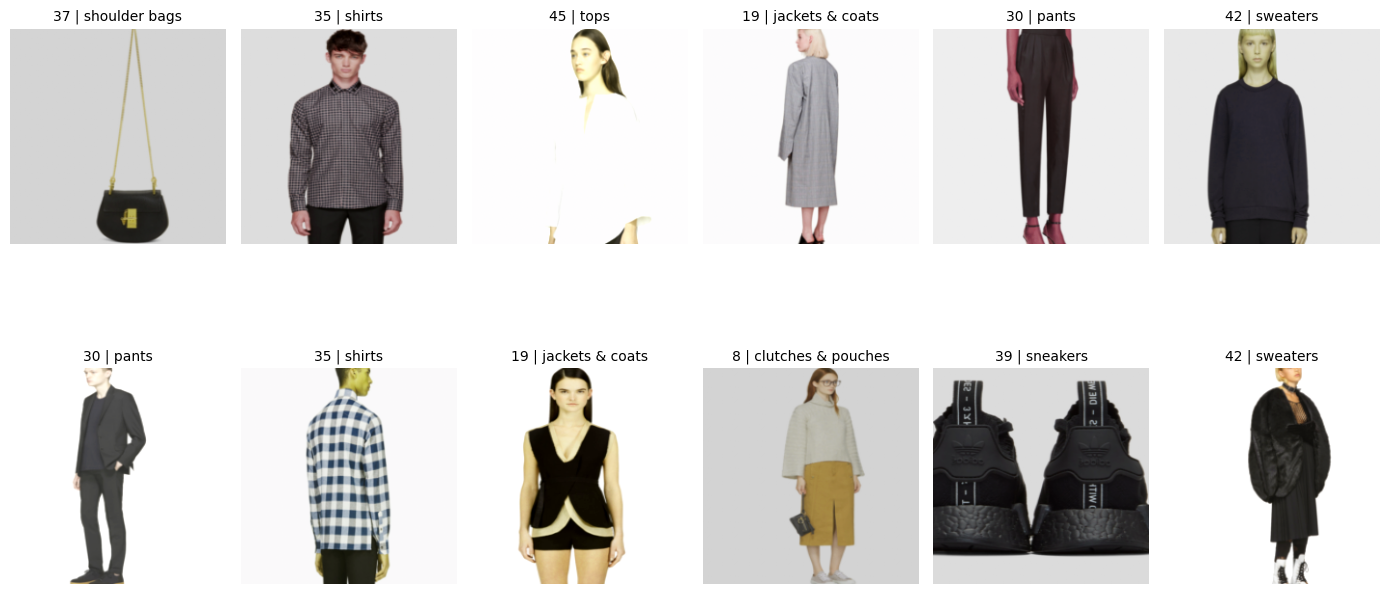

In [27]:
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)


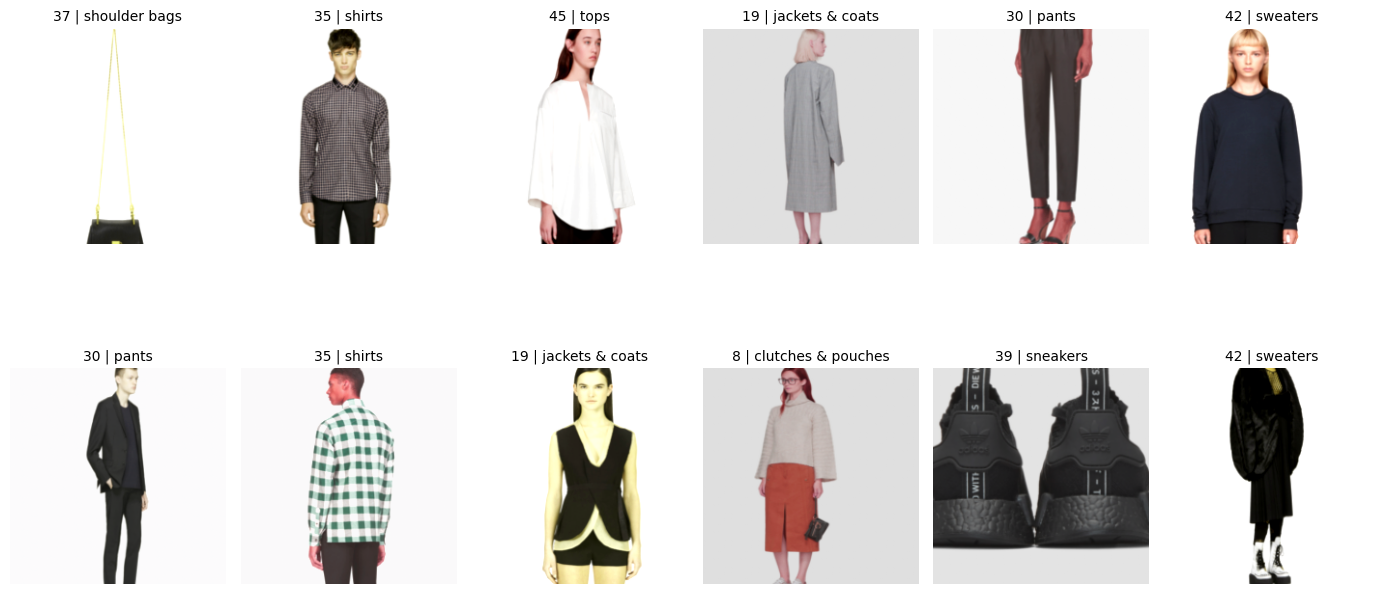

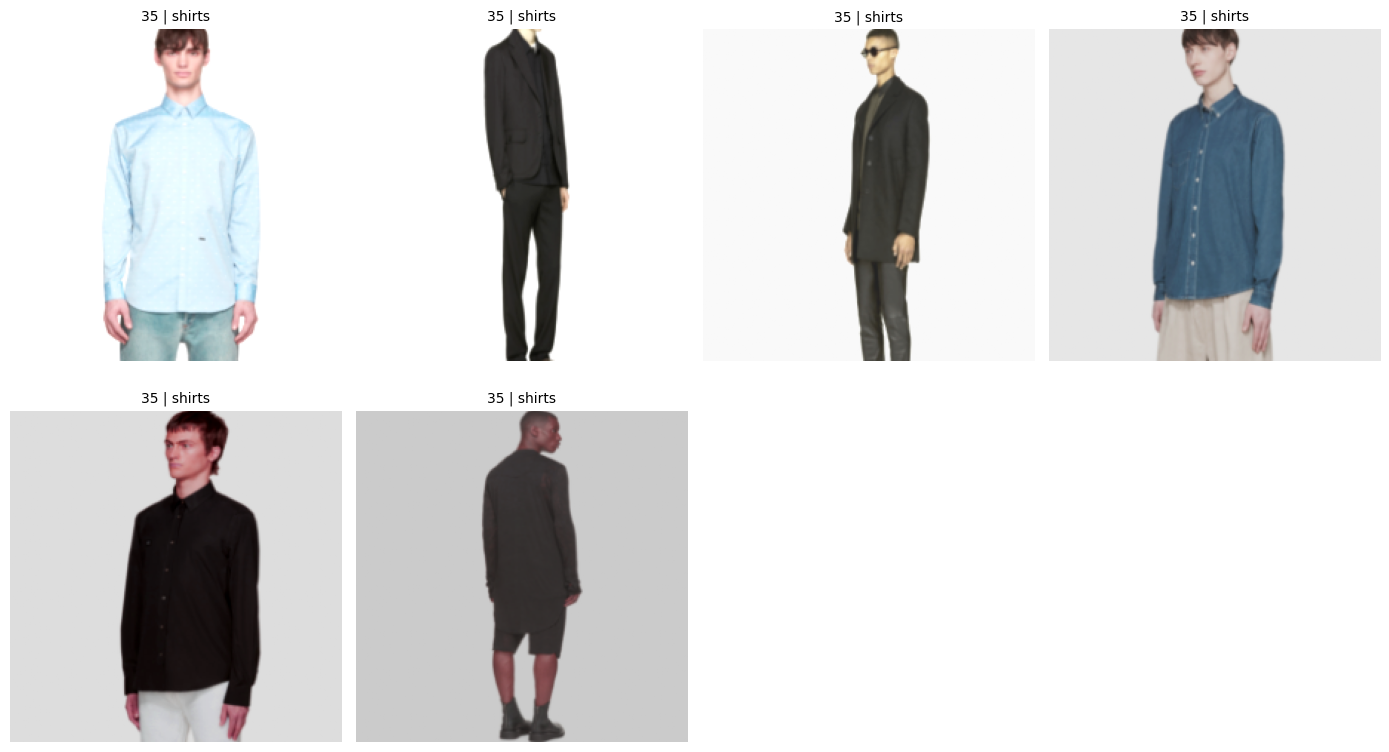

(skipped 1 raw indices not in subset): [12345]


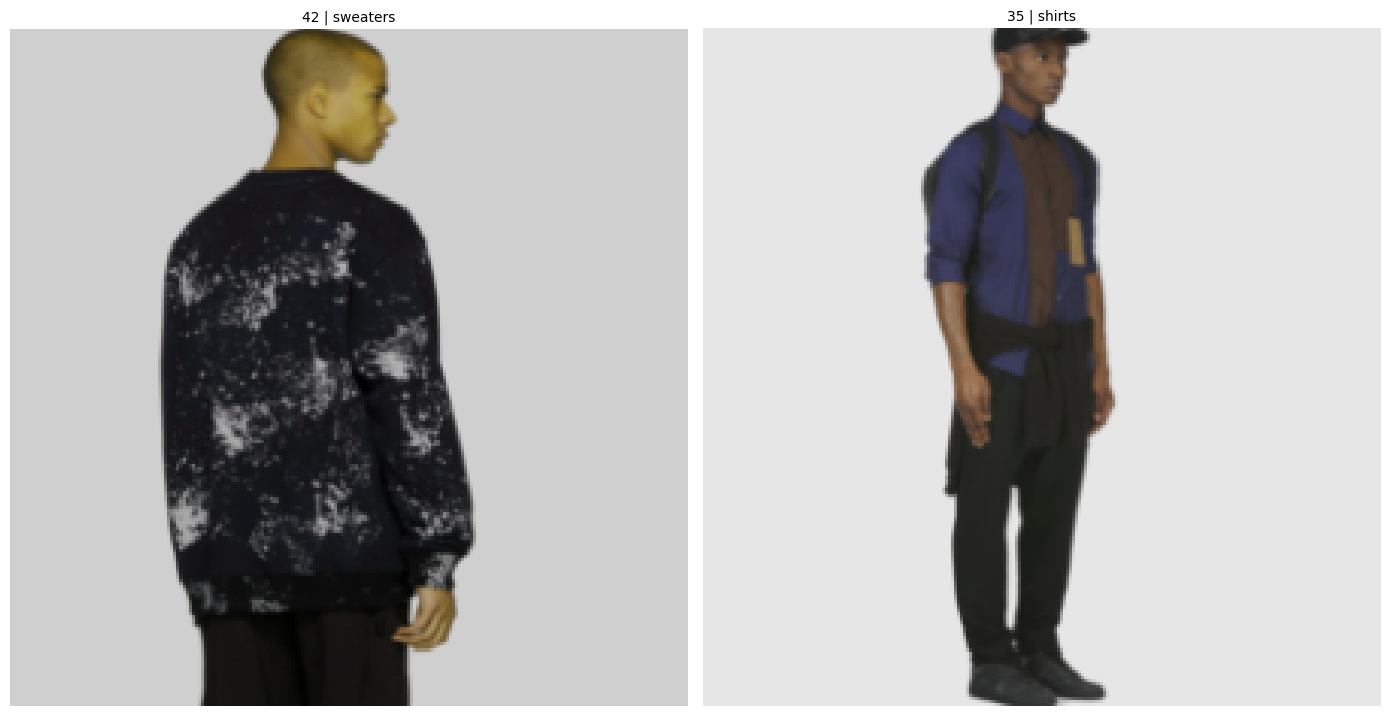

In [28]:
# Random dataset indices
show_samples(train_ds, n=12, ncols=6, norm="imagenet", id2label=id2label)

# Exact dataset indices
show_samples(train_ds, idxs=[0,1,2,3,4,5], id2label=id2label)

# Peek by raw H5 indices (from the original file):
show_by_raw_index(train_ds, raw_idxs=[257594, 100, 12345], id2label=id2label)

In [38]:
def decode_materials(vec, id2mat, max_show=5):
    """
    vec: np.ndarray multi-hot, or None
    returns: comma-joined string of material names (limited)
    """
    if vec is None:
        return None
    if hasattr(vec, "toarray"):  # just in case
        vec = vec.toarray().ravel()
    idxs = np.where(np.asarray(vec) > 0.5)[0]
    names = [id2mat.get(int(i), f"<m:{i}>") for i in idxs]
    if not names:
        return None
    if len(names) > max_show:
        return ", ".join(names[:max_show]) + f" (+{len(names)-max_show})"
    return ", ".join(names)


In [39]:
print("Dataset length:", len(train_ds))
for i in random.sample(range(len(train_ds)), k=5):
    ex = train_ds[i]
    cat = id2label.get(int(ex["label"]), ex["label"])
    gen = id2gen.get(int(ex["gender"]), ex["gender"])
    mat = decode_materials(ex.get("materials"), id2mat)
    cap = (ex["caption"] or "")[:140].replace("\n"," ")
    print(f"[{i}] category={cat} | gender={gen} | material={mat} | caption='{cap}'")

Dataset length: 208375
[137518] category=jackets & coats | gender=men | material=polyester, nylon | caption='Green Down Plus Jacket'
[35356] category=sweaters | gender=women | material=wool, silk | caption='Black Knit Ruffle Sweater'
[105960] category=tops | gender=women | material=cotton | caption='Black Graphic T-Shirt'
[164042] category=dresses | gender=women | material=cotton, nylon, elastane, silk | caption='Black Short Sleeve Velma Dress'
[188414] category=sneakers | gender=men | material=leather, rubber | caption='Black Race 1 Sneakers'


# 4. Multitask Fashion Model

In [21]:
from tqdm.auto import tqdm  # notebook-friendly tqdm

In [22]:
# 1) Build tokenizer from the train dataset captions
captions = [train_ds[i]["caption"] for i in tqdm(range(len(train_ds)))]

  0%|          | 0/208375 [00:00<?, ?it/s]

In [24]:
tok =  TextTokenizer.build_from_captions(captions=captions, min_freq=2, max_size=30000)

In [25]:
print(len(tok.stoi), list(tok.stoi)[:10])


13351 ['<pad>', '<bos>', '<eos>', '<unk>', 'black', 'white', 't-shirt', '&', 'jacket', 'grey']


In [26]:
ids = tok.encode("simple test caption")
print(ids, tok.decode(ids))

[1, 712, 5856, 3, 2] simple test <unk>


In [27]:
captions

['Light Blue Relax Dan Polka Dot Shirt',
 'Black Field Shirt',
 'Green Military Shirt',
 'Indigo Denim Isherwood Shirt',
 'Black Jeffrey Pop Face Shirt',
 'Black Slub Opaled Cardigan',
 'Blue Silk Convertible Shirt',
 'Black Contrast Stripe Shirt',
 'Black Linen Half Double Body Shirt',
 'White Classic Shirt',
 'White Coordinates Shirt',
 'Indigo Dobby Shirt',
 'Grey Plaid Flannel Shirt',
 'White Albacore Merrick Shirt',
 'Grey Plaid Worker Shirt',
 'White Grosgrain Shirt',
 'Navy Typewriter Pattern Shirt',
 'White Classic Shirt',
 'Black Split Neck Shirt',
 'Blue Chambray D-Carry Shirt',
 'Black & White Babycat Spot Print Shirt',
 'Grey & Black Water Print Button-Up Shirt',
 'Black Drawstring Collar Shirt',
 'Blue Long Sleeve Button Down Sash Shirt',
 'Black Mesh-Paneled Shirt',
 'Black Wool Armband Shirt',
 'White Drawstring Shirt',
 'Black Cotton & Silk Faun Tunic Shirt',
 'Black Lewisham Shirt',
 'White Black-Banded Shirt',
 'Black & Ivory Yokohama Shirt',
 'White Monster Logo Prin

In [29]:
# 2) Create model config (enable/disable heads based on vocabs)
cfg = MultiTaskConfig(
    backbone="vit_base_patch16_224",
    proj_dim=512,
    num_categories=len(label_vocab),
    num_genders=len(gen_vocab),
    num_materials=len(mat_vocab),      # ← set this
    vocab_size=len(tok.stoi),
    pad_id=tok.pad_id,
    caption_emb_dim=256,
    caption_layers=1,
    dropout=0.1,
    loss_w_category=1.0,
    loss_w_gender=0.5,
    loss_w_material=1.0,
    loss_w_caption=1.0,
)
model = FashionMultiTaskModel(cfg).to(device)

In [33]:
def collate_with_meta(samples, tokenizer, expect_category, expect_gender, expect_material):
    batch = collate_batch(samples, tokenizer, expect_category, expect_gender, expect_material)
    batch["meta"] = [s.get("meta", {}) for s in samples]
    batch["caption_raw"] = [s.get("caption", "") for s in samples]
    return batch

In [34]:
# 3) DataLoaders with collate
collate_fn = partial(
    collate_with_meta,          
    tokenizer=tok,
    expect_category=(cfg.num_categories is not None),
    expect_gender=(cfg.num_genders is not None),
    expect_material=(cfg.num_materials is not None),
)


train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,  
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, num_workers=8,
    pin_memory=True, persistent_workers=True, worker_init_fn=worker_init_fn,
    collate_fn=collate_fn,
)

print("Loaders rebuilt with custom collate:",
      len(train_ds), len(val_ds), len(test_ds))


Loaders rebuilt with custom collate: 208375 32528 52115


In [35]:
batch = next(iter(train_loader))

print("has material head? ->", hasattr(model, "material_head") and model.material_head is not None)
print("cfg.num_materials   ->", getattr(cfg, "num_materials", None))
print("batch keys          ->", list(batch.keys()))
print("y_material is None? ->", batch.get("y_material") is None)
if batch.get("y_material") is not None:
    print("y_material dtype    ->", batch["y_material"].dtype)
    print("y_material range    ->", int(batch["y_material"].min()), "…", int(batch["y_material"].max()))


has material head? -> True
cfg.num_materials   -> 44
batch keys          -> ['images', 'y_cat', 'y_gender', 'y_material', 'cap_in', 'cap_tgt', 'lengths', 'meta', 'caption_raw']
y_material is None? -> False
y_material dtype    -> torch.int64
y_material range    -> 0 … 14


In [36]:
# 4) Train step
from collections import defaultdict

opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)

def _fmt(d):
    return " | ".join(f"{k}={v:.4f}" for k, v in sorted(d.items()))


epochs = 20
epochs_bar = tqdm(range(epochs), desc="Epochs", position=0, leave=True)

for epoch in epochs_bar:
    model.train()
    sums, n_batches = defaultdict(float), 0

    batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", position=1, leave=False)
    for batch in batch_bar:
        metrics = one_training_step(model, batch, opt, cfg, device)
        for k, v in metrics.items():
            sums[k] += float(v)
        n_batches += 1
    batch_bar.close()

    # final epoch summary
    epoch_avg = {k: sums[k] / max(1, n_batches) for k in sums}
    msg = _fmt(epoch_avg)
    epochs_bar.set_postfix_str(msg, refresh=True)
    tqdm.write(f"[Epoch {epoch+1}/{epochs}] {msg}")  


# opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)

# epochs_bar = tqdm(range(epochs), desc="Epochs", position=0, leave=True)

# for epoch in epochs_bar:
#     model.train()
#     batch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", position=1, leave=False)
#     for step, batch in enumerate(batch_bar, 1):
#         metrics = one_training_step(model, batch, opt, cfg, device)
#         if step % 20 == 0 or step == 1:
#             batch_bar.set_postfix_str(", ".join(f"{k}={v:.4f}" for k,v in metrics.items()), refresh=False)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 1/10] caption_nll=3.5776 | category_ce=0.8116 | gender_ce=0.1875 | material_ce=1.2221 | total=5.7051


Epoch 2/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 2/10] caption_nll=2.7761 | category_ce=0.6225 | gender_ce=0.1230 | material_ce=1.0817 | total=4.5418


Epoch 3/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 3/10] caption_nll=2.4813 | category_ce=0.5568 | gender_ce=0.1059 | material_ce=1.0115 | total=4.1025


Epoch 4/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 4/10] caption_nll=2.2787 | category_ce=0.5111 | gender_ce=0.0934 | material_ce=0.9516 | total=3.7881


Epoch 5/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 5/10] caption_nll=2.1241 | category_ce=0.4746 | gender_ce=0.0854 | material_ce=0.8910 | total=3.5324


Epoch 6/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 6/10] caption_nll=2.0001 | category_ce=0.4459 | gender_ce=0.0791 | material_ce=0.8328 | total=3.3183


Epoch 7/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 7/10] caption_nll=1.8961 | category_ce=0.4175 | gender_ce=0.0747 | material_ce=0.7728 | total=3.1238


Epoch 8/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 8/10] caption_nll=1.8083 | category_ce=0.3920 | gender_ce=0.0708 | material_ce=0.7166 | total=2.9522


Epoch 9/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 9/10] caption_nll=1.7316 | category_ce=0.3708 | gender_ce=0.0646 | material_ce=0.6595 | total=2.7942


Epoch 10/10:   0%|          | 0/3256 [00:00<?, ?it/s]

[Epoch 10/10] caption_nll=1.6631 | category_ce=0.3503 | gender_ce=0.0614 | material_ce=0.6112 | total=2.6553


In [ ]:
Epochs: 100%
 10/10 [35:16<00:00, 212.05s/it, caption_nll=1.6631 | category_ce=0.3503 | gender_ce=0.0614 | material_ce=0.6112 | total=2.6553]
[Epoch 1/10] caption_nll=3.5776 | category_ce=0.8116 | gender_ce=0.1875 | material_ce=1.2221 | total=5.7051
[Epoch 2/10] caption_nll=2.7761 | category_ce=0.6225 | gender_ce=0.1230 | material_ce=1.0817 | total=4.5418
[Epoch 3/10] caption_nll=2.4813 | category_ce=0.5568 | gender_ce=0.1059 | material_ce=1.0115 | total=4.1025
[Epoch 4/10] caption_nll=2.2787 | category_ce=0.5111 | gender_ce=0.0934 | material_ce=0.9516 | total=3.7881
[Epoch 5/10] caption_nll=2.1241 | category_ce=0.4746 | gender_ce=0.0854 | material_ce=0.8910 | total=3.5324
[Epoch 6/10] caption_nll=2.0001 | category_ce=0.4459 | gender_ce=0.0791 | material_ce=0.8328 | total=3.3183
[Epoch 7/10] caption_nll=1.8961 | category_ce=0.4175 | gender_ce=0.0747 | material_ce=0.7728 | total=3.1238
[Epoch 8/10] caption_nll=1.8083 | category_ce=0.3920 | gender_ce=0.0708 | material_ce=0.7166 | total=2.9522
[Epoch 9/10] caption_nll=1.7316 | category_ce=0.3708 | gender_ce=0.0646 | material_ce=0.6595 | total=2.7942
[Epoch 10/10] caption_nll=1.6631 | category_ce=0.3503 | gender_ce=0.0614 | material_ce=0.6112 | total=2.6553

In [43]:
# 5) Simple evaluation (top-1 accuracy per head) =====

@torch.no_grad()
val_metrics = evaluate(model, val_loader, device)
print("Val metrics:", val_metrics)


Eval:   0%|          | 0/509 [00:00<?, ?it/s]

Val metrics: {'category_top1': 0.8044146581406788, 'gender_top1': 0.9662137235612396, 'material_top1': 0.675356615838662, 'caption_nll_per_token': 2.503802654168143, 'caption_ppl': 12.228907964414304}


In [44]:

# Collect predictions & targets on the validation set
@torch.no_grad()
val_out = collect_val_outputs(model, val_loader, tok, device)
len(val_out["cap_ref"]), (None if val_out["cat_true"] is None else len(val_out["cat_true"]))


Collect val outputs:   0%|          | 0/509 [00:00<?, ?it/s]

(32528, 32528)

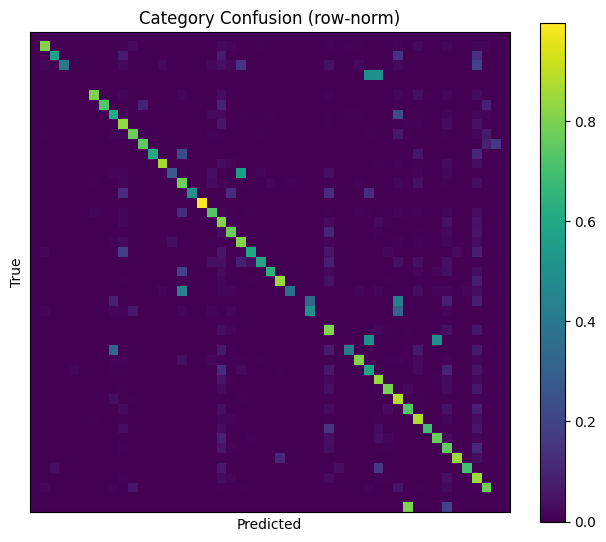

Category per-class accuracy (first 20):
  0            __other__: 0.000
  1            backpacks: 0.811
  2      bag accessories: 0.571
  3   belts & suspenders: 0.400
  4             blankets: 0.000
  5 boat shoes & moccasins: 0.000
  6                boots: 0.802
  7           briefcases: 0.727
  8   clutches & pouches: 0.618
  9              dresses: 0.835
 10 duffle & top handle bags: 0.771
 11          duffle bags: 0.750
 12          espadrilles: 0.611
 13              eyewear: 0.866
 14         fine jewelry: 0.281
 15                flats: 0.777
 16               gloves: 0.500
 17                 hats: 0.996
 18                heels: 0.735
 19      jackets & coats: 0.808


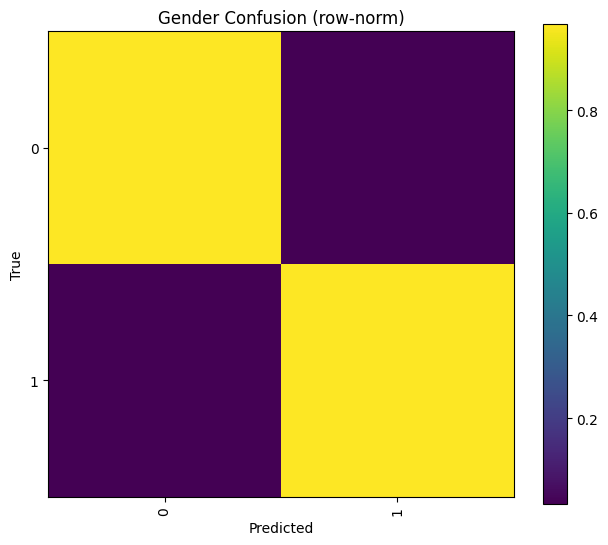

Gender per-class accuracy: {0: 0.965, 1: 0.967}


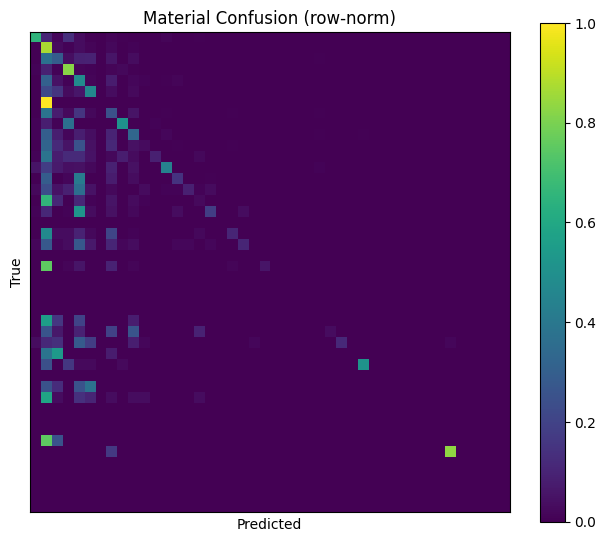

Material per-class accuracy (first 20):
  0            __other__: 0.651
  1               cotton: 0.874
  2            polyester: 0.292
  3              leather: 0.823
  4                 wool: 0.481
  5                nylon: 0.466
  6             elastane: 0.000
  7              viscose: 0.249
  8               rubber: 0.509
  9                 silk: 0.329
 10                cupro: 0.031
 11                   pu: 0.089
 12              acetate: 0.441
 13             cashmere: 0.146
 14              acrylic: 0.088
 15                linen: 0.025
 16               mohair: 0.180
 17                brass: 0.000
 18                modal: 0.104
 19               alpaca: 0.103


In [51]:
# Confusion matrices (normalized rows) + quick per-class accuracy
import numpy as np
import matplotlib.pyplot as plt

def confusion_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[int(t), int(p)] += 1
    return cm

def plot_confusion(cm, class_names=None, title="Confusion (row-norm)"):
    cm = cm.astype(np.float64)
    row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
    cmn = cm / row_sums

    plt.figure(figsize=(6.5, 5.5))
    plt.imshow(cmn, interpolation='nearest')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    if class_names is not None and len(class_names) == cm.shape[0] <= 30:
        plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
        plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
    else:
        plt.xticks([]); plt.yticks([])
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def per_class_accuracy(cm):
    # diag / row sum
    denom = cm.sum(axis=1).clip(min=1)
    acc = np.diag(cm) / denom
    return acc


def idx_to_names(vocab_dict):
    # invert {name: id} → list where i gives name
    inv = [None] * (max(vocab_dict.values()) + 1)
    for k, v in vocab_dict.items():
        inv[v] = k
    return inv

if val_out["cat_true"] is not None:
    cat_names = id2label
    cm_cat = confusion_matrix(val_out["cat_true"], val_out["cat_pred"], len(cat_names))
    plot_confusion(cm_cat, class_names=None, title="Category Confusion (row-norm)")
    cat_acc = per_class_accuracy(cm_cat)
    print("Category per-class accuracy (first 20):")
    for i, a in list(enumerate(cat_acc))[:20]:
        print(f"{i:3d} {cat_names[i] if i < len(cat_names) else i:>20s}: {a:.3f}")

if val_out["gen_true"] is not None:
    gen_names = id2gen
    cm_gen = confusion_matrix(val_out["gen_true"], val_out["gen_pred"], len(gen_names))
    plot_confusion(cm_gen, class_names=gen_names, title="Gender Confusion (row-norm)")
    print("Gender per-class accuracy:", dict(zip(gen_names, per_class_accuracy(cm_gen).round(3))))

if val_out["mat_true"] is not None:
    mat_names = id2mat
    cm_mat = confusion_matrix(val_out["mat_true"], val_out["mat_pred"], len(mat_names))
    plot_confusion(cm_mat, class_names=None, title="Material Confusion (row-norm)")
    mat_acc = per_class_accuracy(cm_mat)
    print("Material per-class accuracy (first 20):")
    for i, a in list(enumerate(mat_acc))[:20]:
        print(f"{i:3d} {mat_names[i] if i < len(mat_names) else i:>20s}: {a:.3f}")


In [52]:
# Caption metrics: BLEU-1/2/4 and ROUGE-L (no heavy deps)
from collections import Counter

def tokenize_simple(s):
    return str(s).strip().lower().split()

def ngrams(tokens, n):
    return [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def corpus_bleu(refs, hyps, max_n=4):
    # refs, hyps: lists of strings
    p_ns = []
    hyp_len = 0
    ref_len = 0
    for n in range(1, max_n+1):
        matches = 0
        total = 0
        for r, h in zip(refs, hyps):
            rt = tokenize_simple(r); ht = tokenize_simple(h)
            hyp_len += (len(ht) if n == 1 else 0)  # only once
            ref_len += (len(rt) if n == 1 else 0)
            r_ngr = Counter(ngrams(rt, n))
            h_ngr = Counter(ngrams(ht, n))
            # clipped precision
            for ng, c in h_ngr.items():
                matches += min(c, r_ngr.get(ng, 0))
                total += c
        p_n = (matches / total) if total > 0 else 0.0
        p_ns.append(p_n)

    # brevity penalty
    bp = 1.0
    if hyp_len < ref_len and hyp_len > 0:
        bp = math.exp(1 - ref_len / hyp_len)

    # geometric mean of p_ns (add small epsilon to avoid log(0))
    eps = 1e-12
    log_prec = sum(math.log(p + eps) for p in p_ns) / max_n
    bleu = bp * math.exp(log_prec)
    return {"BLEU-1": p_ns[0], "BLEU-2": p_ns[1], "BLEU-4": bleu}

def lcs(a, b):
    # classic DP LCS length
    A, B = tokenize_simple(a), tokenize_simple(b)
    dp = [[0]*(len(B)+1) for _ in range(len(A)+1)]
    for i in range(len(A)):
        for j in range(len(B)):
            if A[i] == B[j]:
                dp[i+1][j+1] = dp[i][j] + 1
            else:
                dp[i+1][j+1] = max(dp[i][j+1], dp[i+1][j])
    return dp[-1][-1], len(A), len(B)

def rouge_l(refs, hyps):
    # corpus-level F1 using LCS
    lcs_sum = 0
    ref_sum = 0
    hyp_sum = 0
    for r, h in zip(refs, hyps):
        l, rl, hl = lcs(r, h)
        lcs_sum += l
        ref_sum += rl
        hyp_sum += hl
    prec = lcs_sum / max(1, hyp_sum)
    reca = lcs_sum / max(1, ref_sum)
    if prec + reca == 0:
        f1 = 0.0
    else:
        f1 = 2 * prec * reca / (prec + reca)
    return {"ROUGE-L_P": prec, "ROUGE-L_R": reca, "ROUGE-L_F1": f1}

cap_metrics = {}
if len(val_out["cap_ref"]) > 0:
    cap_metrics.update(corpus_bleu(val_out["cap_ref"], val_out["cap_hyp"], max_n=4))
    cap_metrics.update(rouge_l(val_out["cap_ref"], val_out["cap_hyp"]))

cap_metrics


{'BLEU-1': 0.44380777533150223,
 'BLEU-2': 0.11245592210488903,
 'BLEU-4': 0.08514252834276617,
 'ROUGE-L_P': 0.43915347709784064,
 'ROUGE-L_R': 0.4345012559070203,
 'ROUGE-L_F1': 0.43681497993758356}

In [38]:
# 5) Generate
model.eval()
with torch.no_grad():
    batch = next(iter(val_loader))

    imgs = batch["images"].to(device)  # <-- key is 'images'
    gen_ids = model.generate(imgs, bos_id=tok.bos_id, eos_id=tok.eos_id, max_len=30)

    # helper to decode a padded target row
    def decode_tgt(row_ids):
        # row_ids is a 1D tensor of token ids (targets), ignore pads
        ids = row_ids.tolist()
        return tok.decode(ids)

    B = imgs.size(0)
    for i in range(min(50, B)):
        gen_txt = tok.decode(gen_ids[i].tolist())
        gt_txt = decode_tgt(batch["cap_tgt"][i])

        print("-" * 72)
        print(f"GEN Caption     : {gen_txt}")
        print(f"GT  Caption     : {gt_txt}")


------------------------------------------------------------------------
GEN Caption     : blue denim trucker jacket
GT  Caption     : blue faded elshar jogg jacket
------------------------------------------------------------------------
GEN Caption     : blue denim & leather jacket
GT  Caption     : blue faded elshar jogg jacket
------------------------------------------------------------------------
GEN Caption     : navy denim & leather jacket
GT  Caption     : blue faded elshar jogg jacket
------------------------------------------------------------------------
GEN Caption     : blue denim trucker jacket
GT  Caption     : blue faded elshar jogg jacket
------------------------------------------------------------------------
GEN Caption     : grey distressed thavar jeans
GT  Caption     : light grey distressed slim jeans
------------------------------------------------------------------------
GEN Caption     : grey distressed thavar jeans
GT  Caption     : light grey distressed slim 

In [41]:
# =====9) Generate a few samples + print original meta =====
@torch.no_grad()
def sample_generate_and_print(model, loader, tokenizer, device, k=3, max_len=30):
    model.eval()
    batch = next(iter(loader))
    imgs = batch["images"].to(device)
    gen_ids = model.generate(imgs, bos_id=tokenizer.bos_id, eos_id=tokenizer.eos_id, max_len=max_len)

    B = imgs.size(0)
    for i in range(min(k, B)):
        gen_txt = tokenizer.decode(gen_ids[i].tolist())
        gt_txt  = tokenizer.decode(batch["cap_tgt"][i].tolist())

        meta_i = batch.get("meta", [{}])[i]
        print("-" * 72)
        print(f"Input Name      : {meta_i.get('input_name','N/A')}")
        print(f"Composition     : {meta_i.get('input_composition','N/A')}")
        print(f"GEN Caption     : {gen_txt}")
        print(f"GT  Caption     : {gt_txt}")

sample_generate_and_print(model, val_loader, tok, device, k=3, max_len=30)


------------------------------------------------------------------------
Input Name      : N/A
Composition     : N/A
GEN Caption     : blue denim trucker jacket
GT  Caption     : blue faded elshar jogg jacket
------------------------------------------------------------------------
Input Name      : N/A
Composition     : N/A
GEN Caption     : blue denim & leather jacket
GT  Caption     : blue faded elshar jogg jacket
------------------------------------------------------------------------
Input Name      : N/A
Composition     : N/A
GEN Caption     : navy denim & leather jacket
GT  Caption     : blue faded elshar jogg jacket
